# Ichimoku Cloud Study
## Random Forrest

I want to predict price movements of S&P 500 stocks given bullish crossover signals from Ichimoku clouds. The signal 
has two criteria:
1. Conversion line moves above base line (Crossover)
2. Price is above cloud

### Features
#### Existing
1. ~~open~~
2. ~~high~~
3. ~~low~~
4. ~~close~~
5. ~~volume~~
6. ~~dividend amount~~

#### Technical Indicators
1. ~~tenken_sen~~ (replaced with close_diff_tenkan_sen_percent)
2. ~~kijun_sen~~ (replaced with close_diff_kijun_sen_percent)
3. ~~senkou_span_a~~ (replaced with close_diff_senkou_span_a_percent)
4. ~~senkou_span_b~~ (replaced with close_diff_senkou_span_b_percent)
5. ~~chikou_span~~ (forward bias)
6. RSI (period = 14 day)
7. RMI (time_period = 14 day, momentum_period = 5 day)
8. MFI (period = 14 day)
9. MACD Hist (fastperiod = 12 day, slowperiod = 26 day, signalperiod = 9 day)

#### Engineered
1. close_diff_tenkan_sen_percent
2. close_diff_kijun_sen_percent
3. close_diff_senkou_span_a_percent
4. close_diff_senkou_span_b_percent
5. days_since_earnings
6. crossover_difference
7. crossover_indicator
8. close_price_diff_1_day
9. close_to_365_day_high
10. close_to_365_day_low
12. close_to_{N*7}_day_low
13. volume_percent_of_2_week_total
14. dividend_amount_to_close
15. spy_close_diff_tenkan_sen_percent
16. spy_close_diff_kijun_sen_percent
17. spy_close_diff_senkou_span_a_percent
18. spy_close_diff_senkou_span_b_percent

### Issues
- RandomForestRegressor only predicts positive targets.
- Cross Validation has look-ahead bias. However, the extent to which the trees can manipulate the bias is limited, 
due to time only being appearing as a month (int) in the features.

### Set up notebook

In [1]:
import sys
import os

# This will be the output of '%pwd'
notebook_directory = %pwd
for level in range(3):
    notebook_directory = os.path.dirname(notebook_directory)

sys.path.insert(0, notebook_directory)

%matplotlib inline

### Import Packages

In [2]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import importlib

# After updating the package
import tools.machine_learning_helper
importlib.reload(tools.machine_learning_helper)


from tools.data_helper import process_data, evaluate_for_stationary_series, filter_data
from tools.machine_learning_helper import (asymmetric_mean_squared_error, modified_mean_squared_log_error, 
                                           asymmetric_squared_error_objective,
                                           train_and_test_pipelines, train_test_split_timeseries)
from tools.model_evaluation_helper import (get_accuracy_fig, get_actual_vs_threshold_prob_fig, 
                                           get_actual_vs_pred_prob_fig, get_feature_names, analyze_signal_for_report,
                                           get_med_actual_if_pred_above_thresh_fig)


# TECH DEBT: determine which symbols have high accuracy...

### Load data and process

In [3]:
# data_path = '../../../res/data/s_and_p_study_data_TESTING.h5'
data_path = '../../../res/data/s_and_p_study_data.h5'
df_dict, dropped_symbols = process_data(data_path)

### Prep data and train/test split

In [4]:
# use highest close N days into future for target variable
days_into_future = 10
ohlc_col = 'close'
target_cols = {
    # f'min_{ohlc_col}_next_{days_into_future}_days_percent': {'function_name': 'min'},
    f'max_{ohlc_col}_next_{days_into_future}_days_percent': {'function_name': 'max'}, 
}

drop_cols = [
    'open', 'high', 'low', 'close', 'volume', 'dividend_amount', 'tenkan_sen', 'kijun_sen', 'senkou_span_a', 
    'senkou_span_b', 
    'chikou_span',  # not a known value in real-time.
    ]
target_cols_list = list(target_cols.keys())

test_length = 2
min_date = pd.Timestamp('2010-01-01 16:00:00', tz='US/Eastern')

split_data = train_test_split_timeseries(
    df_dict, target_cols, days_into_future, drop_cols, ohlc_col=ohlc_col, min_date=None, 
    # test_length=1,
    test_date=pd.Timestamp('2023-08-01 16:00:00', tz='US/Eastern'),
    drop_earnings=90-days_into_future
)

index_cols = split_data['index_cols']

df_full = split_data['df_full']
df_train_X = split_data['df_train_X_index'].drop(index_cols, axis=1)
df_train_X['sector'] = df_train_X['sector'].astype('category')
df_train_y = split_data['df_train_y_index'].drop(index_cols, axis=1)
df_test_X = split_data['df_test_X_index'].drop(index_cols, axis=1)
df_test_X['sector'] = df_test_X['sector'].astype('category')
df_test_y = split_data['df_test_y_index'].drop(index_cols, axis=1)

## Set up

In [5]:
preprocessor = ColumnTransformer(
                transformers=[
                    ('cat', OneHotEncoder(handle_unknown='ignore'), ['sector']),
                ], remainder='passthrough')

preprocessor_ss = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['sector']),
        ('num', StandardScaler(), [col for col in df_train_X.columns if col != 'sector']) 
    ])

grid_search_kwargs = {
    'cv': 5,
    'verbose': 2
    
}

## Random Forrest

In [6]:
global_params = {
    'n_estimators': 100,
    'random_state': 5,
    'max_depth': 10,
}

In [7]:

criterion='squared_error'

# n_features_to_select = 64 # pca_feature_count

pipelines = {
    # 'raw_rfe': {
    #     'steps': [
    #         ('preprocessor', preprocessor),
    #         (
    #             'model', 
    #             RFE(        
    #                 RandomForestRegressor(
    #                     n_estimators=n_estimators,
    #                     criterion=criterion,
    #                     random_state=random_state
    #                 ), 
    #                 n_features_to_select=n_features_to_select
    #             )
    #         )
    #     ]
    # },
    # 'pca_rfe': {
    #     'steps': [
    #         ('preprocessor', preprocessor_ss),
    #         ('pca', PCA()),
    #         (
    #             'model', 
    #             RFE(        
    #                 RandomForestRegressor(
    #                     n_estimators=n_estimators,
    #                     criterion=criterion,
    #                     random_state=random_state
    #                 ), 
    #                 n_features_to_select=n_features_to_select
    #             )
    #         )
    #     ]
    # },
    'pca': {
        'steps': [
            ('preprocessor', preprocessor_ss),
            ('pca', PCA()),
            ('model', 
                RandomForestRegressor(
                    n_estimators=global_params['n_estimators'],
                    criterion=criterion,
                    random_state=global_params['random_state'],
                    max_depth=global_params['max_depth'],
                )                
            )
        ]
    },
}

# print(f"Starting model train with {n_features_to_select} features selected")
pipelines = train_and_test_pipelines(df_train_X, df_train_y[target_cols_list[0]], df_test_X, 
                                       df_test_y[target_cols_list[0]], pipelines)


pca: error -0.6388621366428902
Modified Mean Squared Logarithmic Error: 0.00024637669361864427


/Users/seanbearden/PycharmProjects/stock-market-patterns/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/seanbearden/PycharmProjects/stock-market-patterns/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


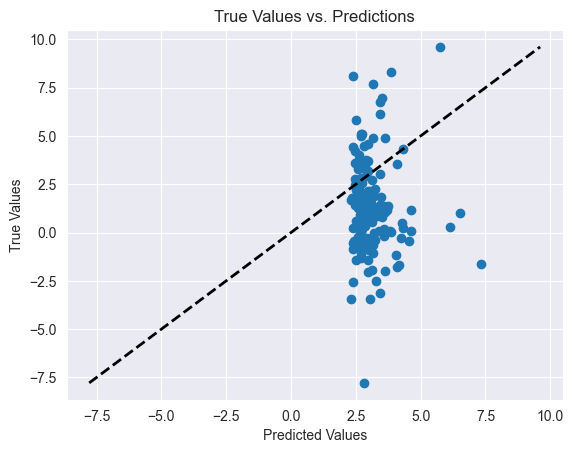

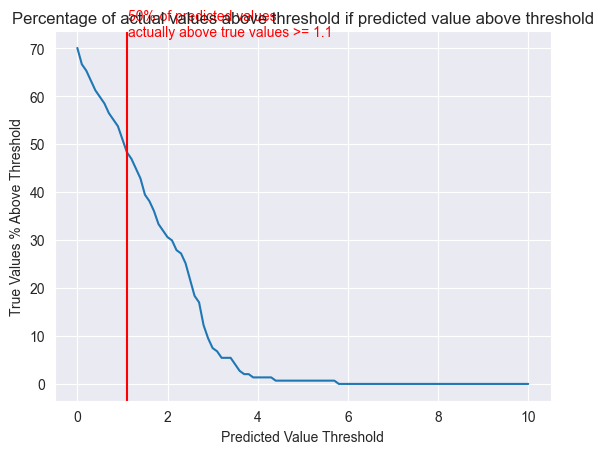

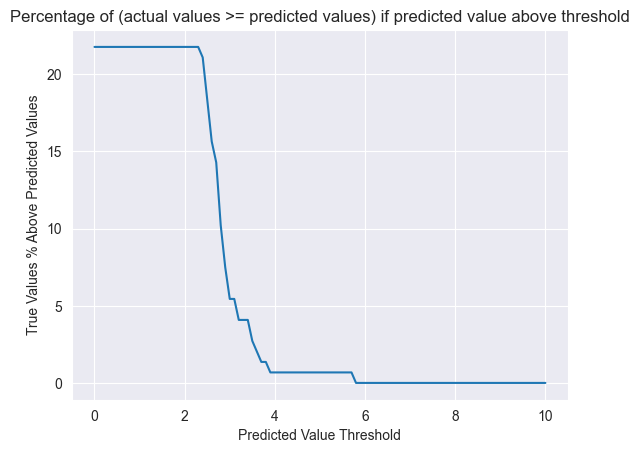

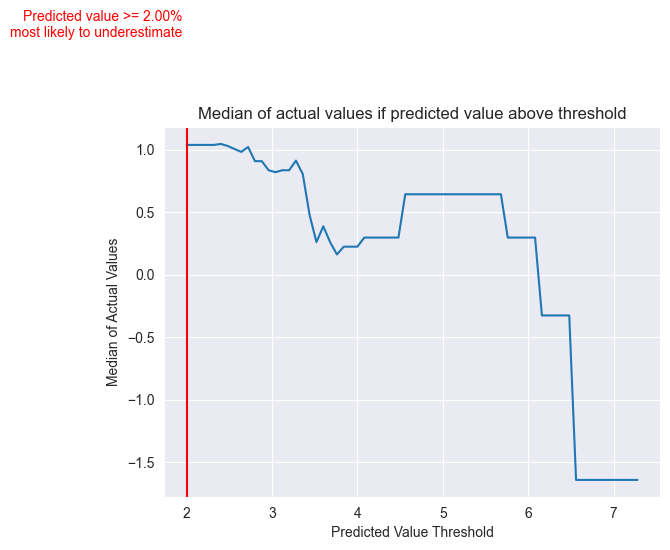

In [8]:
y_pred = pipelines['pca']['pipeline'].predict(df_test_X)
actual_values = df_test_y[target_cols_list[0]] * 100
predicted_values = y_pred * 100

fig_0 = get_accuracy_fig(predicted_values, actual_values)
fig_1 = get_actual_vs_threshold_prob_fig(predicted_values, actual_values, x=None)
fig_2 = get_actual_vs_pred_prob_fig(predicted_values, actual_values, x=None)
fig_3 = get_med_actual_if_pred_above_thresh_fig(predicted_values, actual_values)

## AdaBoost

In [9]:
criterion='squared_error'

ab_pipelines = {
    'raw': {
        'steps': [
            ('preprocessor', preprocessor),
            ('model', AdaBoostRegressor(
                estimator=DecisionTreeRegressor(max_depth=global_params['max_depth'], criterion=criterion, 
                                                random_state=global_params['random_state']),
                n_estimators=global_params['n_estimators']))
        ]
    },
}

ab_pipelines = train_and_test_pipelines(df_train_X, df_train_y[target_cols_list[0]], df_test_X, 
                                       df_test_y[target_cols_list[0]], ab_pipelines)

raw: error -0.872210585356211
Modified Mean Squared Logarithmic Error: 0.0002813199514203755


/Users/seanbearden/PycharmProjects/stock-market-patterns/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/seanbearden/PycharmProjects/stock-market-patterns/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


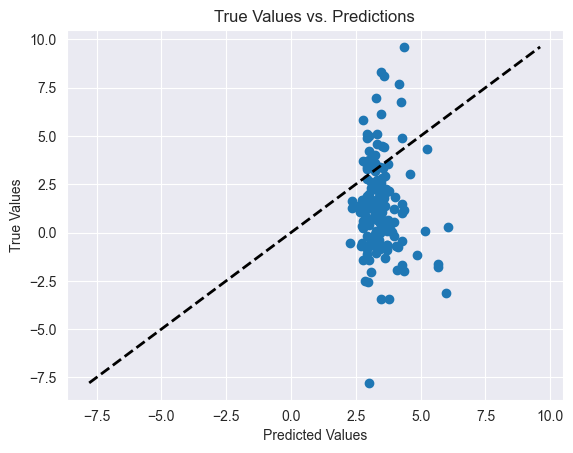

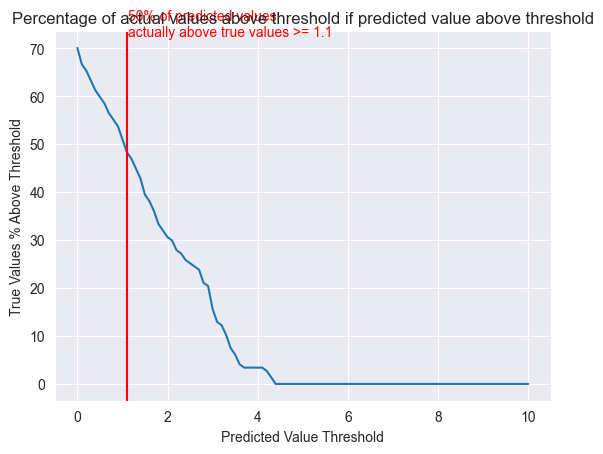

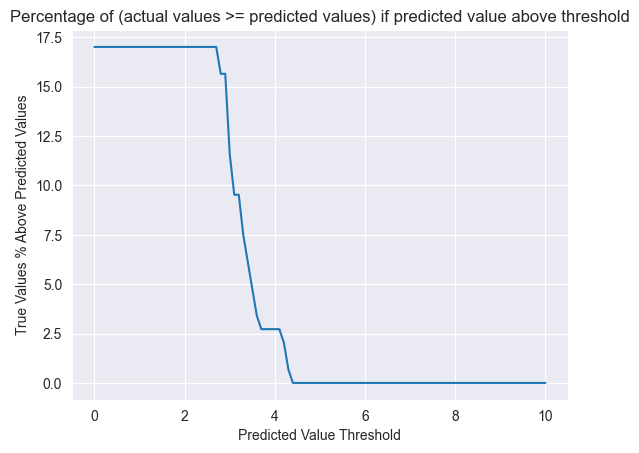

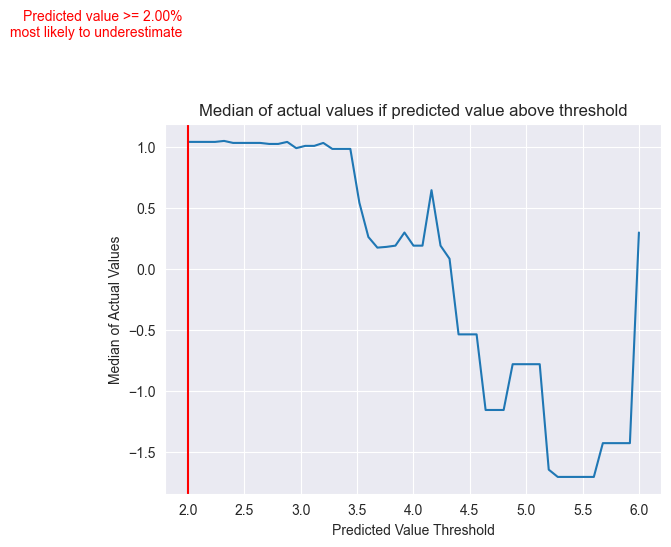

In [10]:
y_pred = ab_pipelines['raw']['pipeline'].predict(df_test_X)
actual_values = df_test_y[target_cols_list[0]] * 100
predicted_values = y_pred * 100

fig_0 = get_accuracy_fig(predicted_values, actual_values)
fig_1 = get_actual_vs_threshold_prob_fig(predicted_values, actual_values, x=None)
fig_2 = get_actual_vs_pred_prob_fig(predicted_values, actual_values, x=None)
fig_3 = get_med_actual_if_pred_above_thresh_fig(predicted_values, actual_values)

## Gradient Boosting

In [11]:
criterion='friedman_mse'

gb_pipelines = {
    'pca': {
        'steps': [
            ('preprocessor', preprocessor_ss),
            ('pca', PCA()),
            ('model', GradientBoostingRegressor(
                n_estimators=global_params['n_estimators'],
                criterion=criterion,
                random_state=global_params['random_state'],
                max_depth=global_params['max_depth'], 
                )
            )
        ]
    },
}

gb_pipelines = train_and_test_pipelines(df_train_X, df_train_y[target_cols_list[0]], df_test_X, 
                                       df_test_y[target_cols_list[0]], gb_pipelines)

pca: error -1.2645388151032857
Modified Mean Squared Logarithmic Error: 0.0003390019756844399


/Users/seanbearden/PycharmProjects/stock-market-patterns/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/seanbearden/PycharmProjects/stock-market-patterns/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


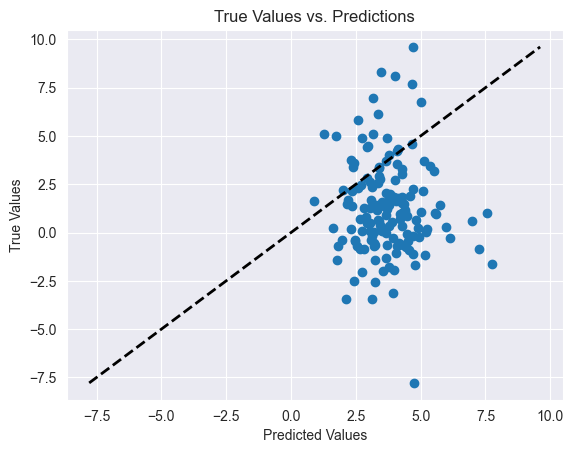

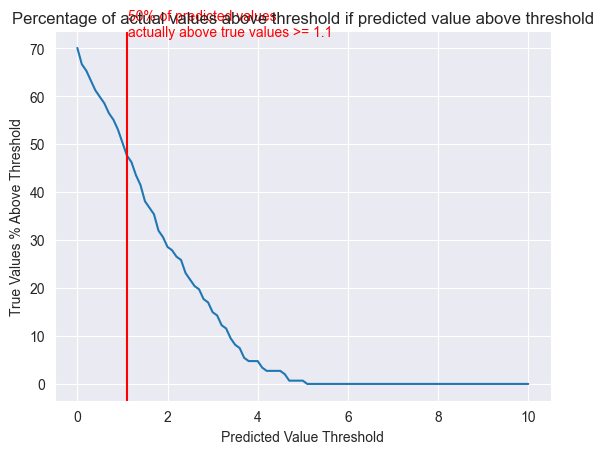

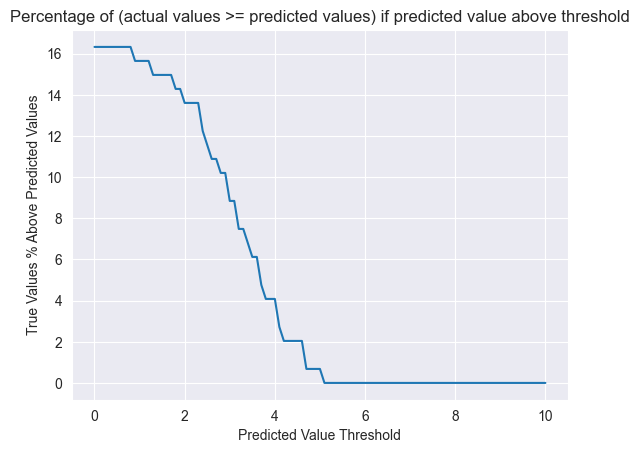

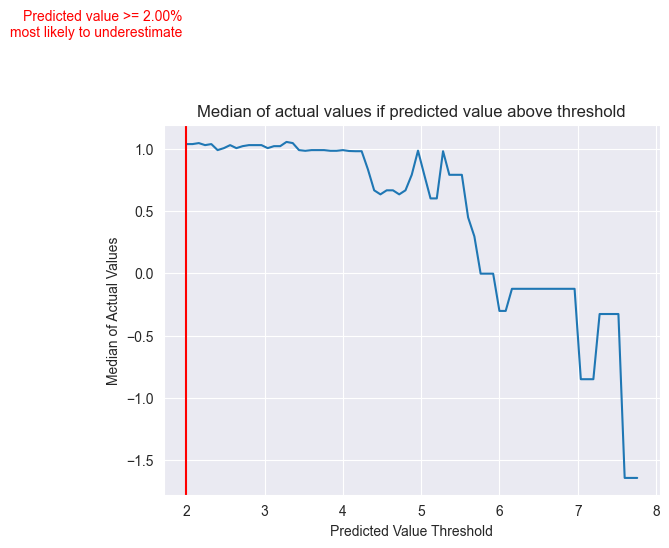

In [12]:
y_pred = gb_pipelines['pca']['pipeline'].predict(df_test_X)
actual_values = df_test_y[target_cols_list[0]] * 100
predicted_values = y_pred * 100

fig_0 = get_accuracy_fig(predicted_values, actual_values)
fig_1 = get_actual_vs_threshold_prob_fig(predicted_values, actual_values, x=None)
fig_2 = get_actual_vs_pred_prob_fig(predicted_values, actual_values, x=None)
fig_3 = get_med_actual_if_pred_above_thresh_fig(predicted_values, actual_values)

## Stochastic Gradient Boosting

In [13]:
criterion='friedman_mse'
subsample=0.8
max_features=0.5

sgb_pipelines = {
    'raw': {
        'steps': [
            ('preprocessor', preprocessor),
            ('model', GradientBoostingRegressor(
                n_estimators=global_params['n_estimators'],
                subsample=subsample,
                max_features=max_features,
                criterion=criterion,
                random_state=global_params['random_state'],
                max_depth=global_params['max_depth'],
                )
            )
        ]
    },
    # 'pca': {
    #     'steps': [
    #         ('preprocessor', preprocessor_ss),
    #         ('pca', PCA()),
    #         ('model', GradientBoostingRegressor(
    #             # max_depth=max_depth, 
    #             # subsample=subsample,
    #             # max_features=max_features,
    #             criterion=criterion,
    #             random_state=random_state, 
    #             # n_estimators=n_estimators
    #             )
    #         )
    #     ],
    #     'params_grid': {
    #         'pca__n_components': [0.85],
    #         'model__n_estimators': [250],
    #         'model__max_depth': [2, 3, 4],
    #         'model__max_features': [0.25],
    #         'model__subsample': [0.95]
    #     },
    #     # 'scoring': make_scorer(asymmetric_mean_squared_error, greater_is_better=False)
    # },
}

sgb_pipelines = train_and_test_pipelines(df_train_X, df_train_y[target_cols_list[0]], df_test_X, 
                                       df_test_y[target_cols_list[0]], sgb_pipelines, grid_search_kwargs)


raw: error -1.3150634943996473
Modified Mean Squared Logarithmic Error: 0.00034598645689384736


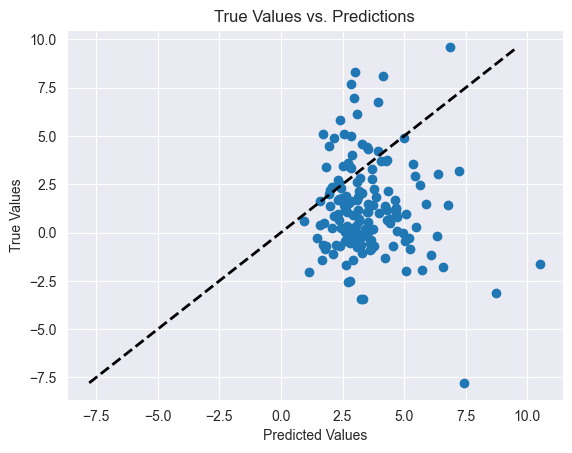

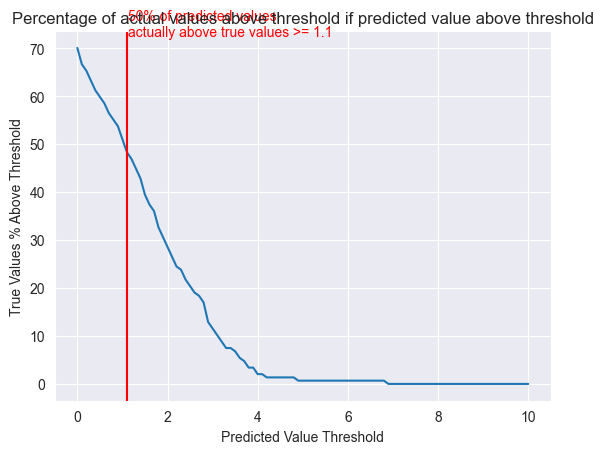

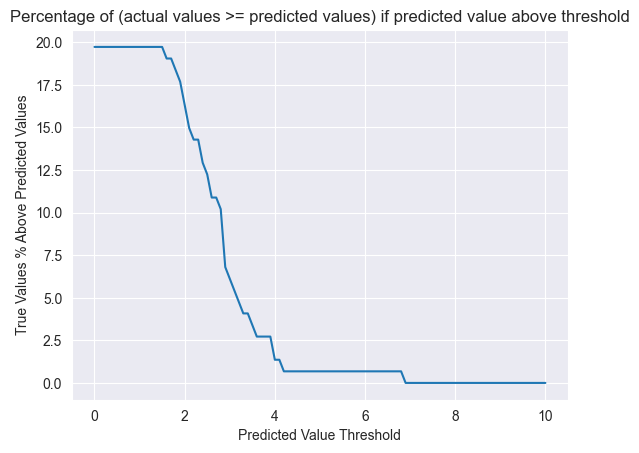

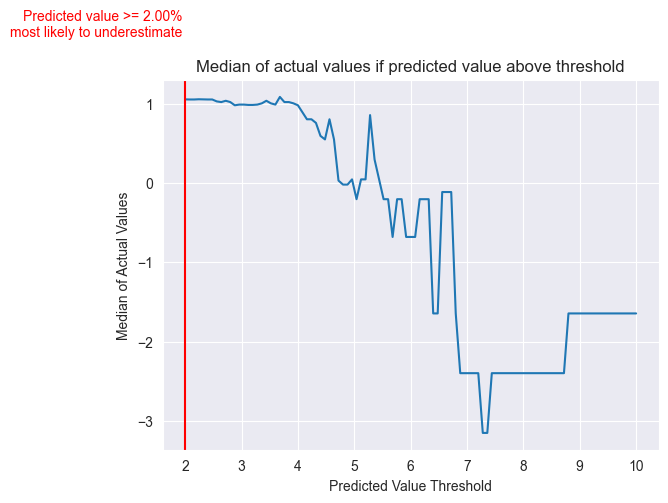

In [14]:
y_pred = sgb_pipelines['raw']['pipeline'].predict(df_test_X)
actual_values = df_test_y[target_cols_list[0]] * 100
predicted_values = y_pred * 100

fig_0 = get_accuracy_fig(predicted_values, actual_values)
fig_1 = get_actual_vs_threshold_prob_fig(predicted_values, actual_values, x=None)
fig_2 = get_actual_vs_pred_prob_fig(predicted_values, actual_values, x=None)
fig_3 = get_med_actual_if_pred_above_thresh_fig(predicted_values, actual_values)

In [ ]:
tscv = TimeSeriesSplit(n_splits=10)

tscv_kwargs = {'cv': tscv,
              'verbose': 3}

xgb_pipelines = {
    'pca': {
        'steps': [
            ('preprocessor', preprocessor),
            # ('pca', PCA()),
            ('model', xgb.XGBRegressor(
                objective='reg:squaredlogerror', 
                # objective=partial(asymmetric_squared_error_objective, weight_over=1, weight_under=1),
                seed=global_params['random_state'],
                # eval_metric=make_scorer(partial(asymmetric_mean_squared_error, multiplier=2), 
                #                         greater_is_better=False),
                enable_categorical=True,
                verbosity=2,
            )
            )
        ],
        'params_grid': {
            # 'pca__n_components': [0.85, 0.99],
            'model__n_estimators': [2000],
            'model__max_depth': [25],
            # 'model__subsample': [0.5],
            'model__colsample_bytree': [0.5]
        },
        # 'scoring': make_scorer(asymmetric_mean_squared_error, greater_is_better=False)
    },
}



xgb_pipelines = train_and_test_pipelines(
    df_train_X, 
    df_train_y[target_cols_list[0]], 
    df_test_X, 
    df_test_y[target_cols_list[0]], 
    xgb_pipelines, 
    tscv_kwargs)


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END model__colsample_bytree=0.5, model__max_depth=25, model__n_estimators=2000;, score=-0.157 total time=   1.7s
[CV 2/10] END model__colsample_bytree=0.5, model__max_depth=25, model__n_estimators=2000;, score=-0.074 total time=   3.0s
[CV 3/10] END model__colsample_bytree=0.5, model__max_depth=25, model__n_estimators=2000;, score=-0.044 total time=   4.2s
[CV 4/10] END model__colsample_bytree=0.5, model__max_depth=25, model__n_estimators=2000;, score=-0.104 total time=   4.8s
[CV 5/10] END model__colsample_bytree=0.5, model__max_depth=25, model__n_estimators=2000;, score=-0.205 total time=   4.9s
[CV 6/10] END model__colsample_bytree=0.5, model__max_depth=25, model__n_estimators=2000;, score=0.114 total time=   6.7s


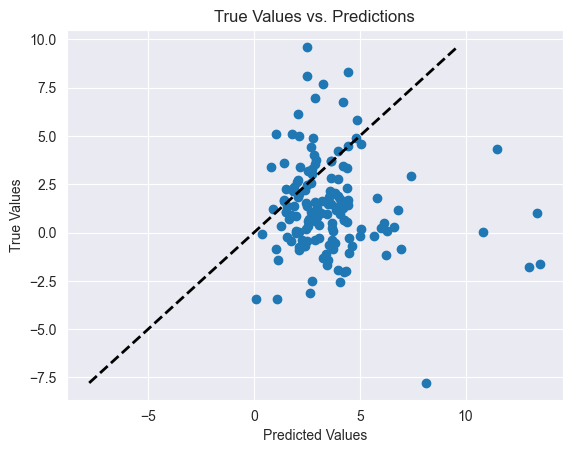

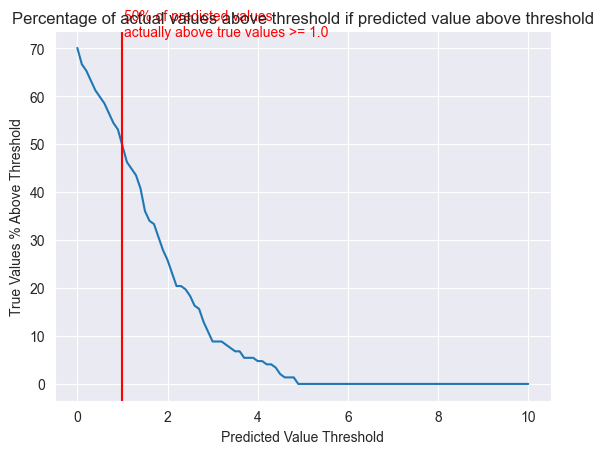

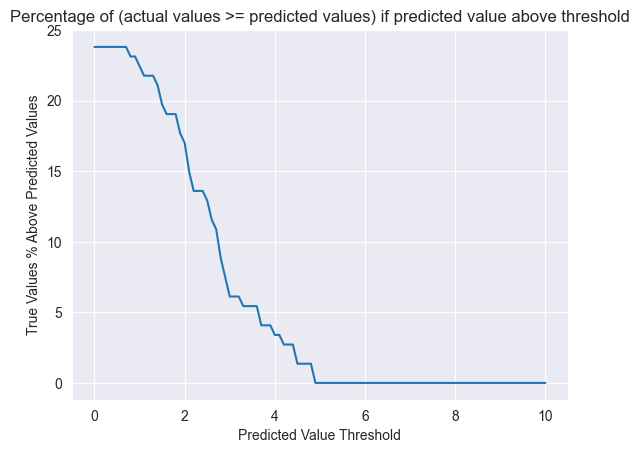

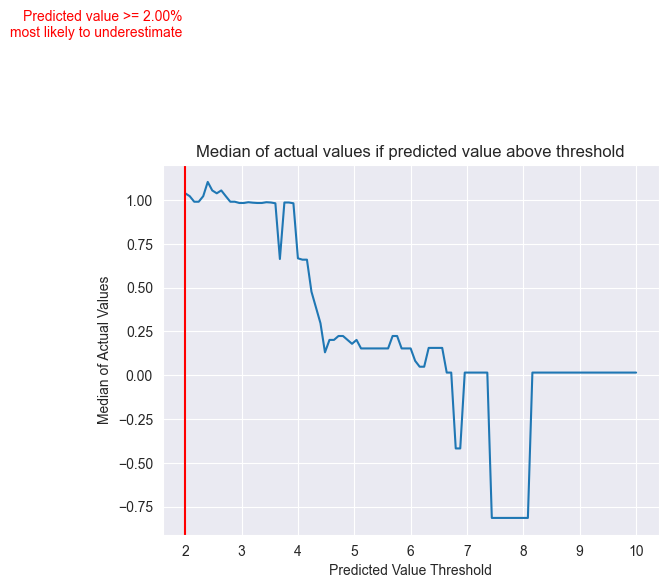

In [21]:
y_pred = xgb_pipelines['pca']['pipeline'].predict(df_test_X)
actual_values = df_test_y[target_cols_list[0]] * 100
predicted_values = y_pred * 100

fig_0 = get_accuracy_fig(predicted_values, actual_values)
fig_1 = get_actual_vs_threshold_prob_fig(predicted_values, actual_values, x=None)
fig_2 = get_actual_vs_pred_prob_fig(predicted_values, actual_values, x=None)
fig_3 = get_med_actual_if_pred_above_thresh_fig(predicted_values, actual_values)

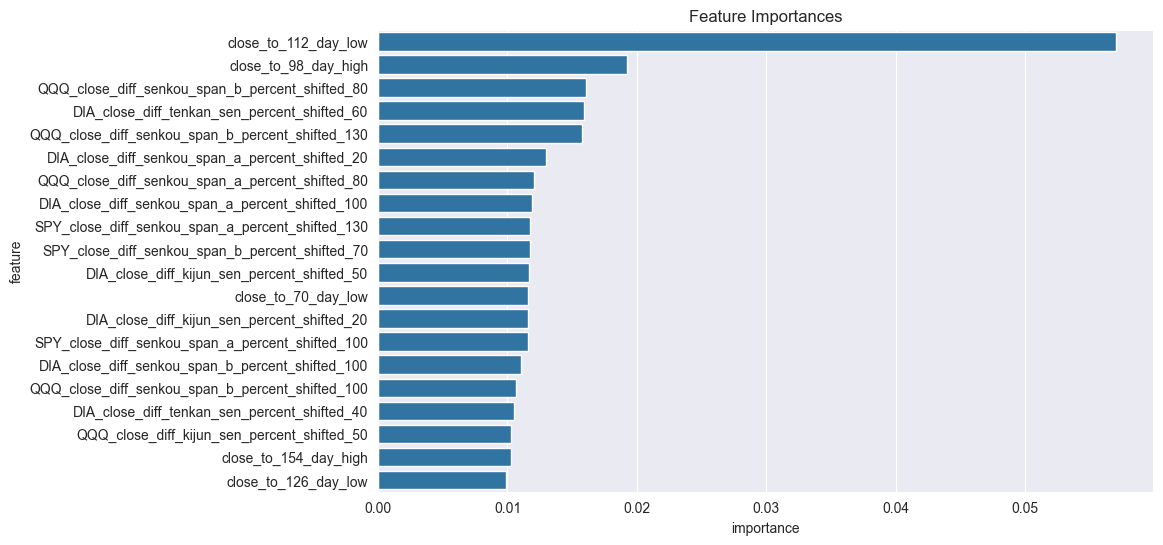

In [22]:
xgb_model = xgb_pipelines['pca']['pipeline']

# Retrieve the preprocessor and the model from the pipeline
preprocessor = xgb_model.named_steps['preprocessor']
model = xgb_model.named_steps['model']

# Get feature names
feature_names = get_feature_names(preprocessor)

# Map feature names with feature importances
feature_importances = model.feature_importances_
feature_dict = dict(zip(feature_names, feature_importances))

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame(feature_dict.items(), columns=['feature', 'importance']).sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df.iloc[:20])
plt.title('Feature Importances')
plt.show()

In [23]:
# After updating the package
import tools.backtesting_helper as bth
importlib.reload(tools.backtesting_helper)

prediction_theshold = 0.025
total_trades = 0
pnl_perc = []
for test_idx in df_test_X.index:
    y_pred = xgb_pipelines['pca']['pipeline'].predict(df_test_X.loc[[test_idx]])
    
    if y_pred[0] > prediction_theshold:
        total_trades += 1
        df_test_case = split_data['df_test_X_index'].loc[test_idx]
        
        df_symbol = df_dict[f"/prices/{df_test_case['symbol']}"]
        i_location = df_symbol.index.get_loc(df_test_case.date)
        next_10_rows = df_symbol.iloc[i_location + 1 : i_location + 11]
        
        entry_info = {
            'direction': 'long',
            'entry_price': df_symbol.loc[df_test_case.date].close, # assume close is entry
        }
        
        exit_criteria = {
            'limit': df_symbol.loc[df_test_case.date].close * (1 + y_pred[0]), 
            'stop': df_symbol.loc[df_test_case.date].close * (1 - 0.75*y_pred[0]), 
            'max_hold_days': 3*days_into_future, 
            'signals': []
        }
        
        pnl_perc.append(bth.trade_signal(next_10_rows, entry_info, exit_criteria))
print(total_trades, f"{100*np.sum(pnl_perc): .1f}%")

sell at stop value -2.7%
sell at stop value -3.2%
sell at end value 0.8%
sell at stop value -2.6%
sell at limit value 2.7%
sell at end value 1.8%
sell at stop value -2.4%
sell at limit value 2.8%
sell at stop value -2.4%
sell at limit value 4.2%
sell at end value -0.4%
sell at end value -1.3%
sell at limit value 4.4%
sell at end value -0.7%
sell at stop value -1.9%
sell at stop value -3.3%
sell at stop value -2.0%
sell at end value -1.6%
sell at open value (stop) -2.3%
sell at end value -5.4%
sell at end value -1.5%
sell at limit value 2.9%
sell at limit value 4.8%
sell at end value -0.4%
sell at limit value 4.9%
sell at end value 2.0%
sell at stop value -2.8%
sell at stop value -3.8%
sell at stop value -2.0%
sell at stop value -2.8%
sell at limit value 2.8%
sell at stop value -3.8%
sell at stop value -2.6%
sell at end value 1.0%
sell at stop value -6.1%
sell at stop value -2.6%
sell at stop value -4.7%
sell at stop value -2.7%
sell at stop value -2.9%
sell at stop value -2.7%
sell at 

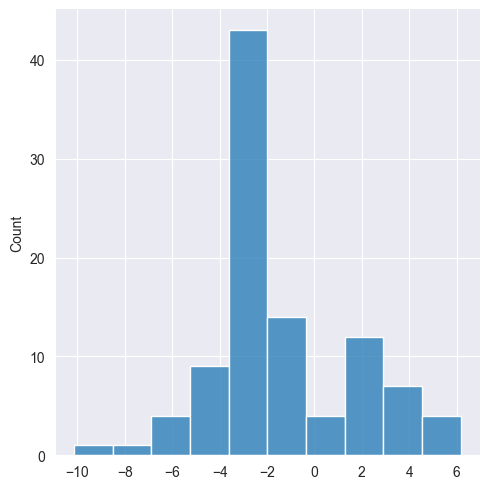

In [24]:
sns.displot([100*p for p in pnl_perc])